# 1. Setup

In [1]:
import pickle
from time import time

from lightgbm import LGBMRegressor, plot_tree
from matplotlib.patches import Patch
import plotly.express as px
from scipy.optimize import curve_fit
from scipy.stats import entropy
import shap
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import sklearn as skl

from utils import *

# 2. Load data and models

## 2.1. Data

In [2]:
trips = pd.read_parquet('../data/trips.parquet').disp()

727,167 rows x 31 cols; Memory: 50.6 MiB


,RawDuration,Duration,Distance,Speed,LogDistance,Mode,Purpose,HomeBased,VehType,Weekend,...,MSAKind,UrbanO,UrbanD,PopDensityO,PopDensityD,HouseDensityO,HouseDensityD,EmpDensityO,EmpDensityD,Weight
,<int64>,<float64>,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>,<category>,...,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<float64>
0,15,16.182075,8.439379,31.291583,3.926362,Drive,Social,Yes,Car,No,...,Small,Suburban,Suburban,Mid,Low,Mid,Low,Mid,Low,1.0


In [3]:
X = pd.get_dummies(trips.select_dtypes(CAT), prefix_sep='__')

In [4]:
feature_grps = pd.concat([
    Pdf(D(feature=trips.loc[:, start: end].columns)).assign(group=grp) 
    for grp, (start, end) in {
        'Trip': ('Mode', 'StartTime'),
        'SES': ('Age', 'HomeOwn'),
        'OD': ('MSAKind', 'EmpDensityD')
    }.items()]).reset_index(drop=1).disp()

25 rows x 2 cols; Memory: 0.0 MiB


,feature,group
,<object>,<object>
0,Mode,Trip


## 2.2. Models

In [5]:
# models = D(pd.read_pickle('../data/model_comparison.pickle')
#            .query('model=="Light Gradient Boost"')
#            .set_index('target').estimator)
models = load_pickle('../data/selected_models.pickle')
models['Duration']

LGBMRegressor(learning_rate=0.05, n_jobs=-1, random_state=1234, verbosity=-1)

# 3. SHAP analysis

## 3.1. Compute values

### 3.1.1. For factor levels

In [6]:
def get_shap(models, X=X, seed=12345, overwrite=False):
    outpath = Path('../data/shap_levels.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    res = []
    for target in tqdm(['Distance', 'Duration']):
        explainer = shap.TreeExplainer(models[target], seed=seed)
        shaps = explainer(X).values
        df = Pdf(shaps, columns=X.columns).astype(np.float32)
        df = df.rename_axis('row_id').reset_index().astype(D(row_id=np.int32))
        # nullify 'Other' vehicle types since they correspond to other modes
        if 'VehType__Other' in df: df['VehType__Other'] = 0
        df.insert(0, 'target', target)
        res.append(df)
    res = pd.concat(res).reset_index(drop=1).astype(D(target=CAT))
    res.to_parquet(mkfile(outpath))
    return res

shap_level = get_shap(models, overwrite=1).disp() # t=1:15

  0%|          | 0/2 [00:00<?, ?it/s]

1,454,334 rows x 74 cols; Memory: 411.9 MiB


,target,row_id,Mode__Drive,Mode__Transit,Mode__Walk,Mode__Bike,Purpose__Work,Purpose__Shopping,Purpose__Social,Purpose__Medical,...,HouseDensityO__High,HouseDensityD__Low,HouseDensityD__Mid,HouseDensityD__High,EmpDensityO__Low,EmpDensityO__Mid,EmpDensityO__High,EmpDensityD__Low,EmpDensityD__Mid,EmpDensityD__High
,<category>,<int32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,...,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
0,Distance,0,0.040092,-0.050949,0.931701,0.037006,0.089213,-0.035537,2.632936,0.259948,...,-0.025905,1.265378,0.030674,-0.013179,0.319529,0.008223,0.000776,0.051334,0.03529,0.006639


### 3.1.2. Aggregate to factors

In [7]:
def get_feature_contrib(shap_level, features=feature_grps.feature):
    shap_feature = shap_level[['target', 'row_id']]
    for feat in features:
        col = np.abs(shap_level.filter(like=feat + '__')).sum(1).rename(feat)
        shap_feature = pd.concat([shap_feature, col], axis=1)
    res = ((shap_feature.drop(columns='row_id')
            .groupby('target').apply(sum) / (len(shap_feature) / 2))
           .reset_index().melt('target', var_name='feature', value_name='abs_shap'))
    return res

shap_feature_contrib = get_feature_contrib(shap_level).disp()

50 rows x 3 cols; Memory: 0.0 MiB


,target,feature,abs_shap
,<category>,<object>,<float64>
0,Distance,Mode,1.917714


## 3.2. Feature & level contributions

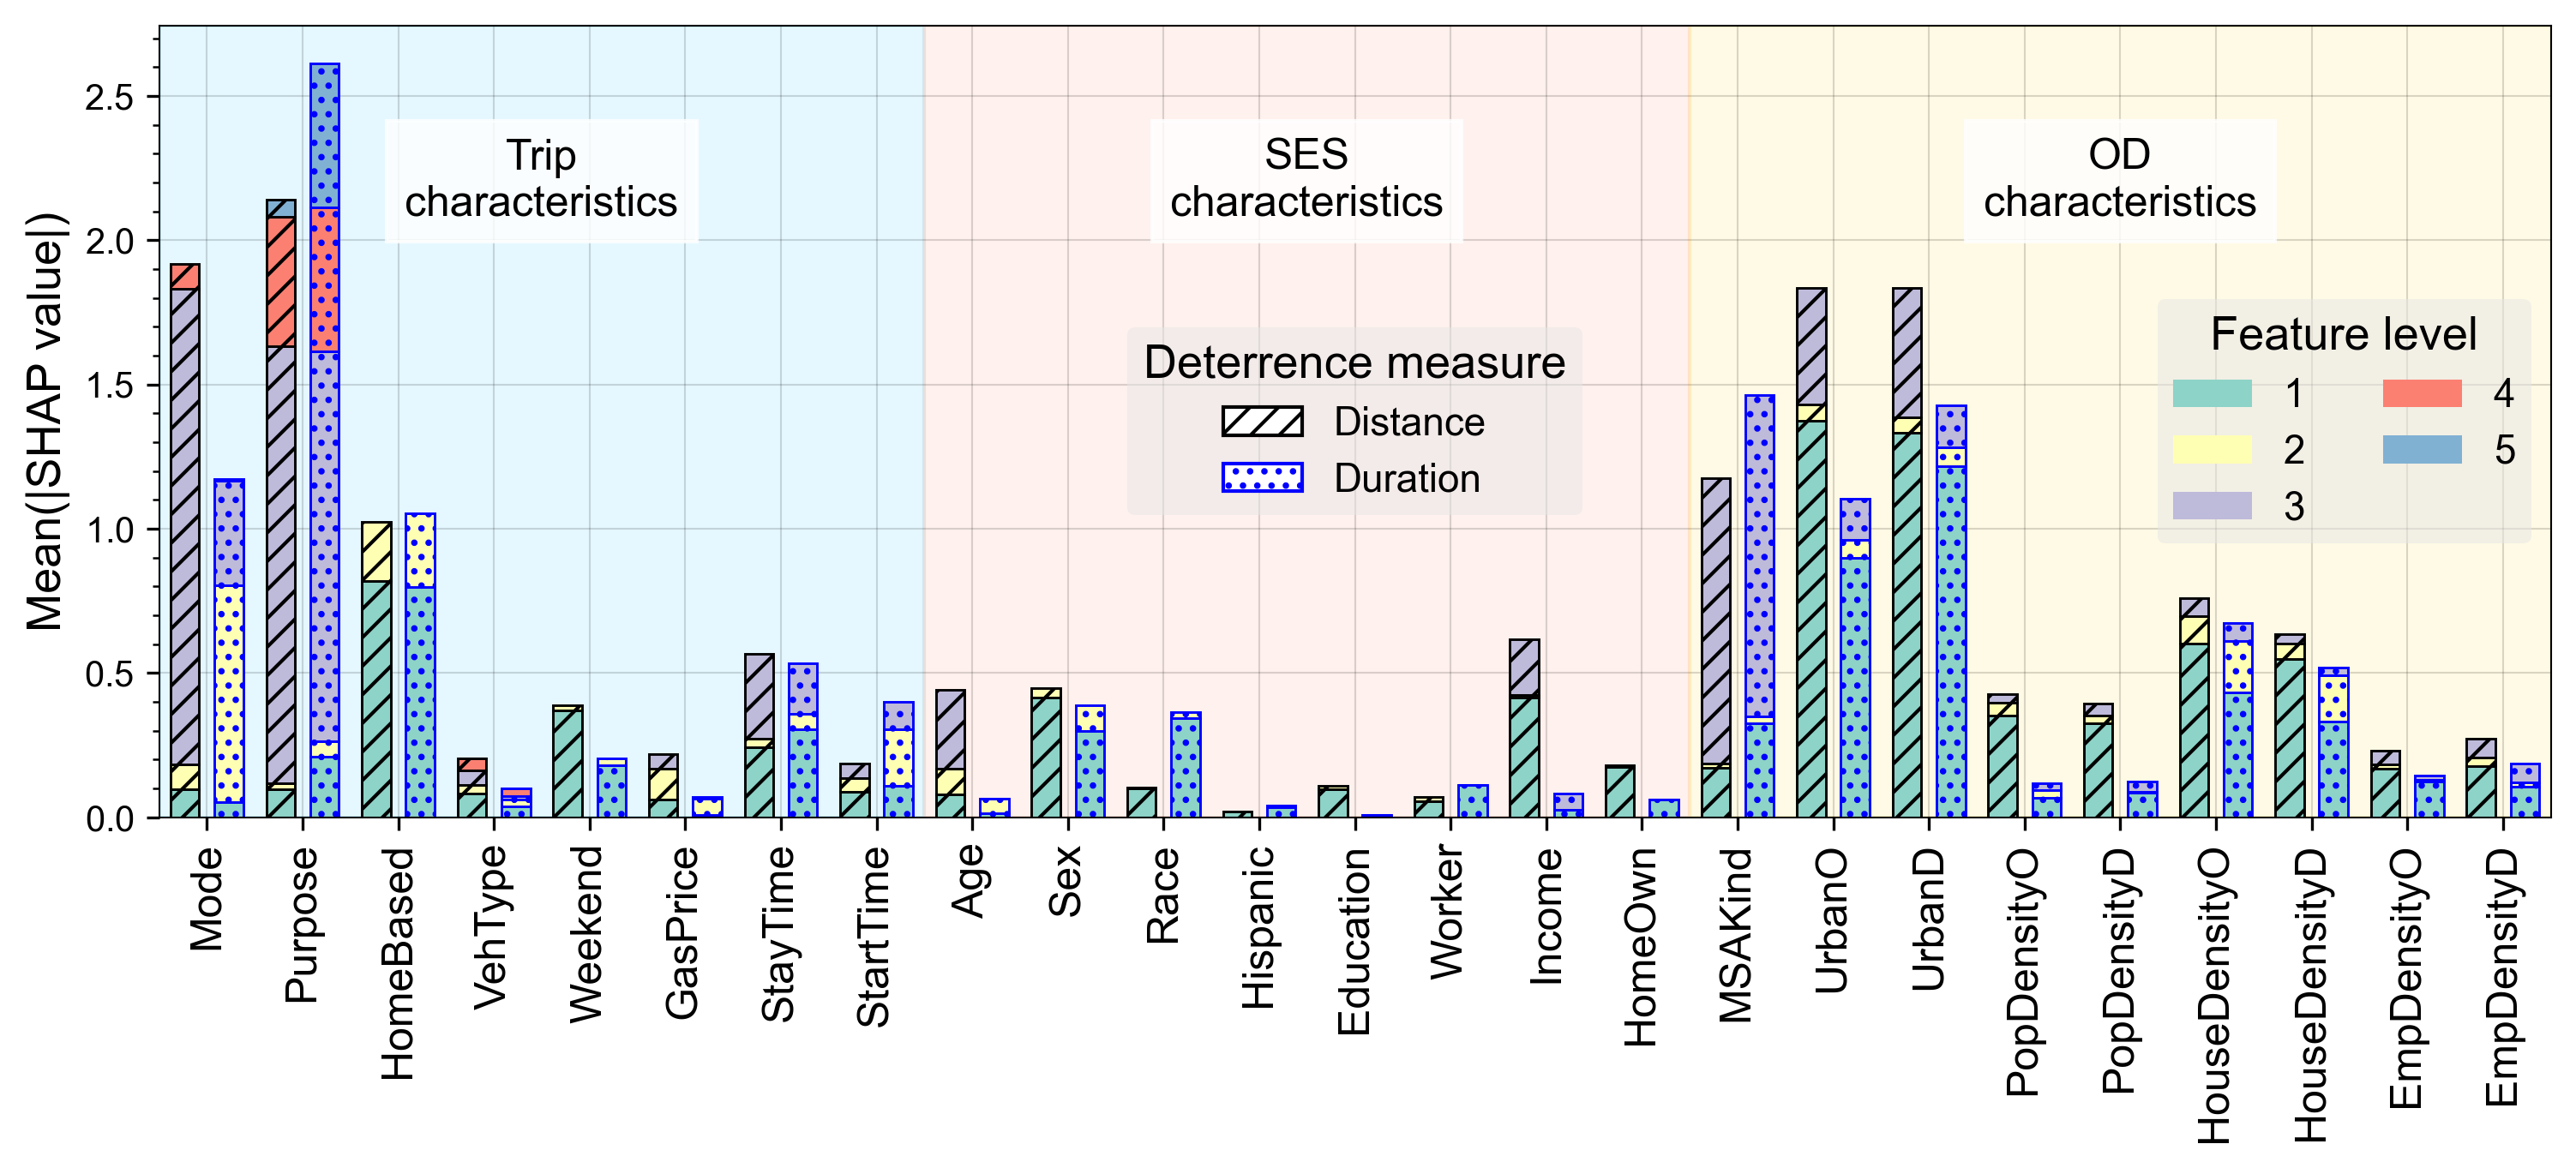

In [8]:
def fig_feature_selection2(shaps, feats=feature_grps, dx=0.08, width=0.3,
                           size=(12, 4), dpi=150, cmap='Set3'):
    sh = np.abs(shaps.drop(columns='row_id').set_index('target'))
    sh = sh.groupby('target').mean(0).reset_index().melt('target')
    sh['feature'] = sh.variable.str.split('__').str[0]
    sh['level'] = sh.variable.str.split('__').str[1]
    grps = feats.groupby('group', sort=0).size().rename('width').reset_index()
    grps['start'] = grps.width.cumsum().shift().fillna(0)
    ax = pplot(size=size, dpi=dpi, ylab='Mean(|SHAP value|)', xminor=0)
    targets = [('Distance', 'k', '///'), ('Duration', 'b', '...')]
    ymax = 0
    for i, (trg, color, hatch) in enumerate(targets):
        for j, feat in enumerate(feats.feature):
            df = sh.query(f'target=="{trg}" & feature=="{feat}"').copy()
            df['bottom'] = df.value.cumsum().shift().fillna(0)
            df['color'] = sns.color_palette(cmap, len(df)).as_hex()
            ymax = max(ymax, df.value.sum())
            for _, r in df.iterrows():
                x = j + (2 * i - 1) * (dx + width / 2) - width / 2
                ax.add_artist(mpl.patches.Rectangle(
                    (x, r.bottom), width, r.value,
                    color=r.color, ec=color, lw=0.7, hatch=hatch))
    ax.set_xticks(range(len(feats)), feats.feature, rotation=90, fontsize=12)
    ax.set_xlim(-0.5, len(feats) - 0.5)
    ax.set_ylim(0, 1.05 * ymax)
    for (_, r), color in zip(grps.iterrows(), ['deepskyblue', 'coral', 'gold']):
        ax.axvspan(r.start - 0.5, r.start + r.width - 0.5, color=color, alpha=0.1, zorder=-1)
        ax.text(r.start - 0.5 + r.width / 2, 0.9 * ymax, f'{r.group}\ncharacteristics',
                color='k', ha='center', va='top', fontsize=12,
                bbox=D(pad=5, color='w', alpha=0.8))
    leg1 = plt.legend(loc='center', title='Deterrence measure', handles=[
        mpl.patches.Patch(fc='w', ec=c, hatch=h, label=l) for l, c, h in targets])
    plt.gca().add_artist(leg1)
    max_levels = sh.groupby(['target', 'feature']).size().max()
    colors = sns.color_palette(cmap, max_levels)
    labels = [str(i + 1) for i in range(len(colors))]
    plt.legend(loc='center right', ncol=2, title='Feature level', handles=[
        mpl.patches.Patch(fc=c, ec='none', label=l) for c, l in zip(colors, labels)])
    imsave('SHAP values by feature and level')

x = fig_feature_selection2(shap_level, dpi=300); x # t=0:04

# 4. Reduce factors

## 4.1. PCA for clustering groups

In [9]:
def plot_pca_contrib(cols, ncomps, shaps=shap_level, trips=trips,
                     size=(12, 5), dpi=150, cmap='terrain', rotation=90):
    df, ncol = trips[cols], len(cols)
    cols = list(pd.get_dummies(df, prefix_sep='__').columns)
    _, axes = plt.subplots(2, 2, figsize=size, dpi=dpi,
                           gridspec_kw=D(width_ratios=[1, 10]))
    for i, (target, ncomp) in enumerate(ncomps.items()):
        X = shaps.query(f'target=="{target}"')[cols]
        pca = PCA(ncol).fit(X)
        ## Panel A: Explained variance ratios
        contrib = pca.explained_variance_ratio_ * 100
        df = Pdf(D(val=contrib))
        ax = pplot(axes[i, 0], ylab='% explained variance')
        colors = sns.color_palette(cmap, ncol)
        ax = df.T.plot(ax=ax, kind='bar', stacked=True, color=colors, alpha=0.8)
        df['pos'] = (df.val.cumsum() + df.val.cumsum().shift().fillna(0)) / 2
        for _, r in df.iloc[:ncomp].iterrows():
            ax.text(0, r.pos, f'PC {r.name + 1}: {r.val:.1f}%', ha='center', va='center')
        ax.get_legend().remove()
        ax.set_xticklabels([])
        ## Panel B: Individual component multipliers
        df = Pdf(pca.components_[:ncomp, :].T).assign(col=X.columns)
        df = df.melt('col', var_name='PC', value_name='mult')
        df.PC += 1
        ax = pplot(axes[i, 1], xminor=0)
        sns.barplot(df, ax=ax, x='col', y='mult', hue='PC', palette=colors[:ncomp], alpha=0.8)
        ax.axhline(0, ls='--', color='k', lw=0.75)
        ax.set_ylabel('Component multiplier')
        ax.set_xlabel('')
        df = Pdf(D(col=X.columns, feat=[x.split('__')[0] for x in X.columns]))
        for x in list(df.feat.drop_duplicates().index) + [ncol]:
            ax.axvline(x - 0.5, color='k', alpha=0.3, lw=2)
        ax.set_xticklabels([x.split('__')[1] for x in X.columns] if i == 1 else [], rotation=rotation)
    plt.tight_layout()

# od_cols = [x for x in feature_grps.query('group=="OD"').feature if x not in ['MSAKind']]
# x = plot_pca_contrib(od_cols, D(Duration=2, LogDistance=3), rotation=90, dpi=150); x

In [10]:
# ses_cols = feature_grps.query('group=="SES"').feature
# x = plot_pca_contrib(ses_cols, D(Duration=2, LogDistance=4), rotation=0, dpi=150); x

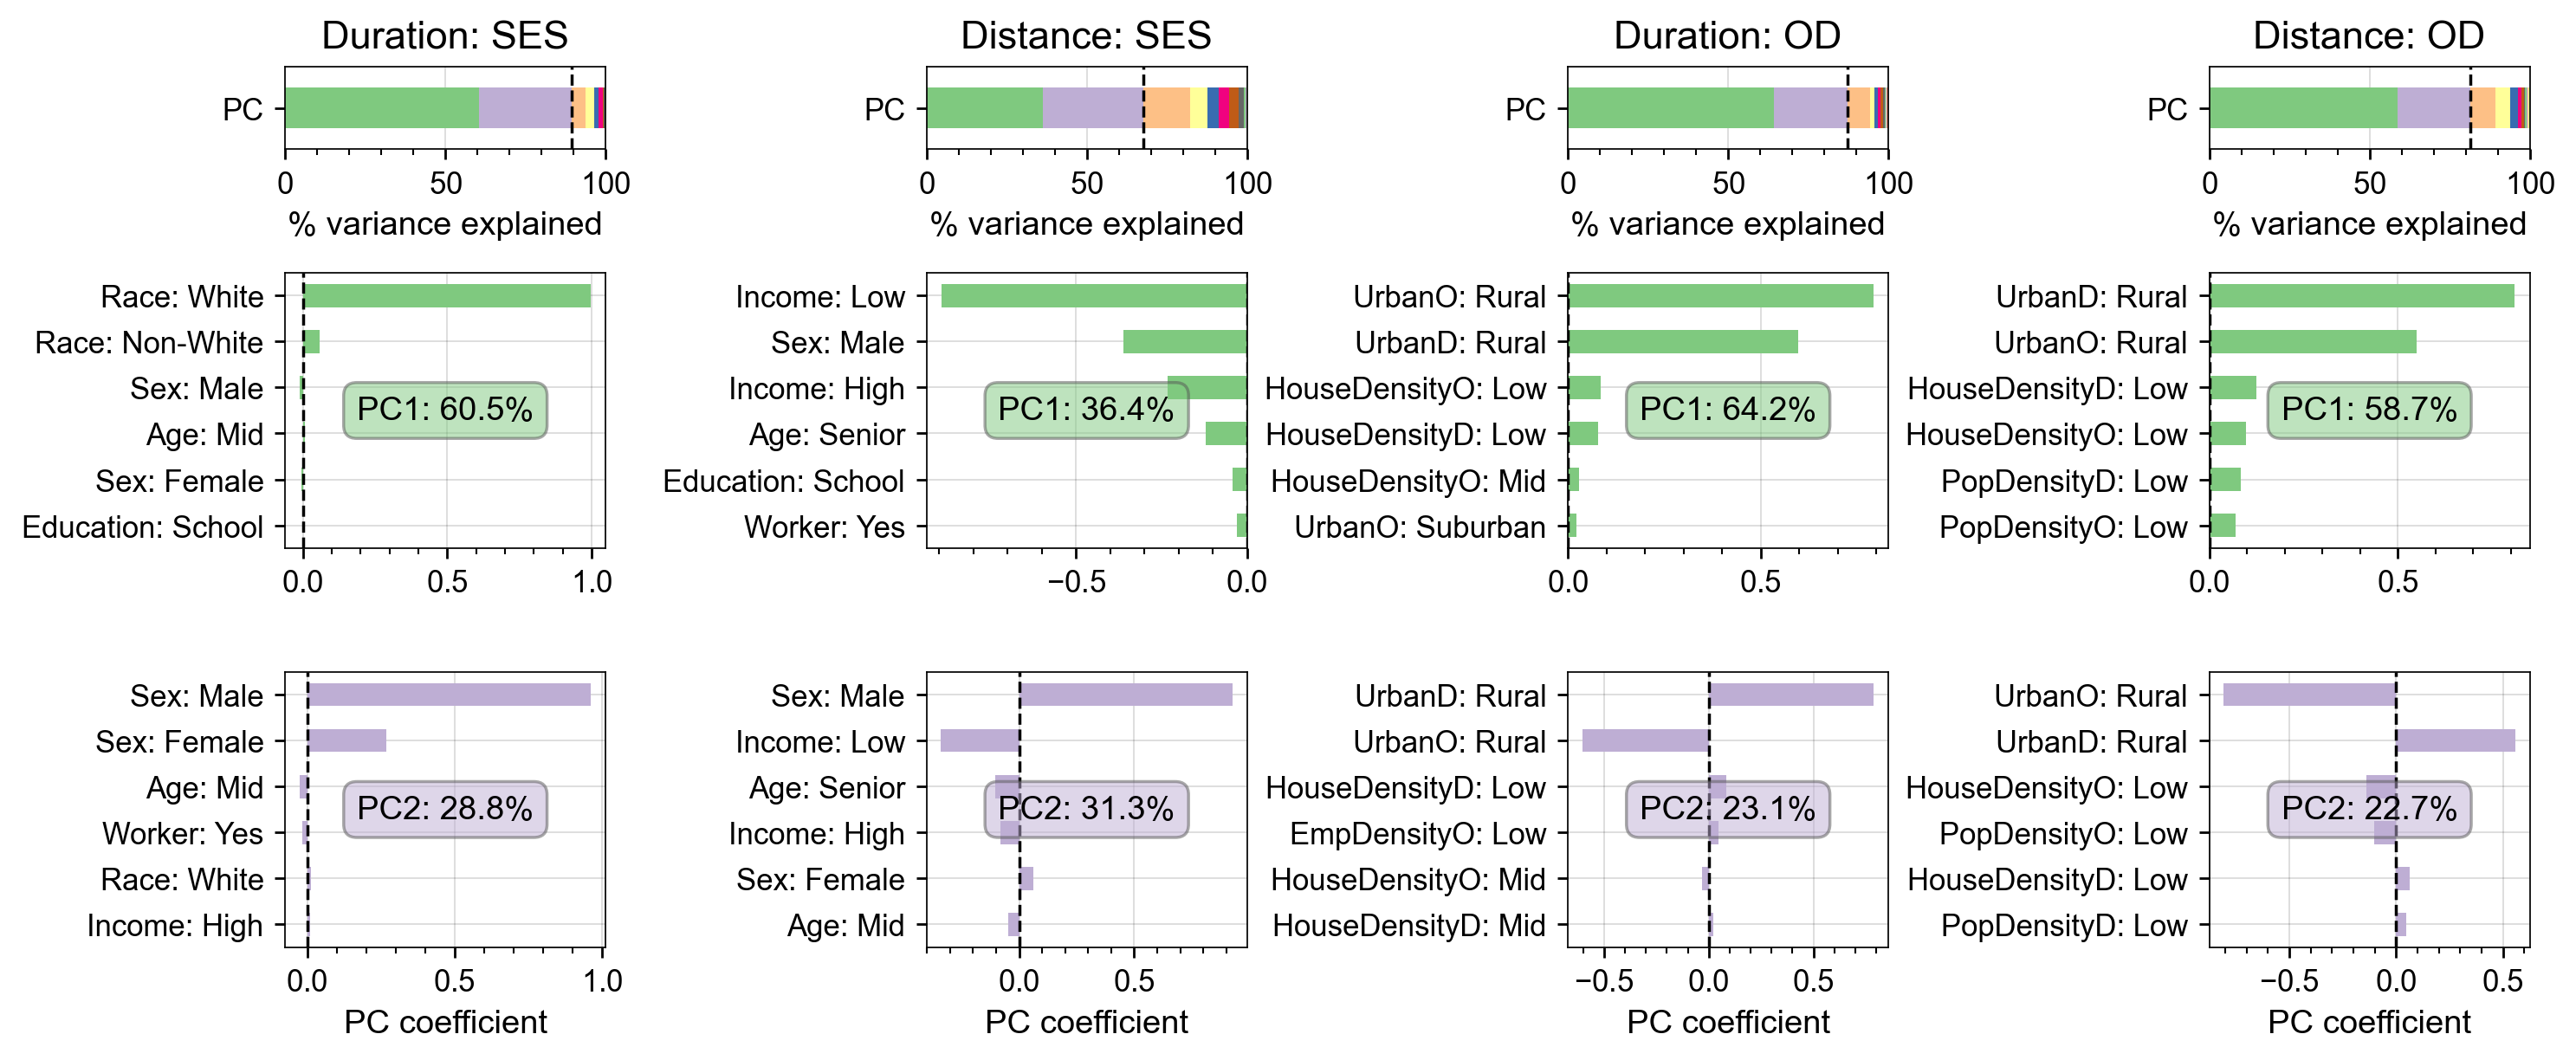

In [20]:
def fig_pca_clust(shaps=shap_level, ncomp=2, top=6, size=(12, 5), dpi=150, cmap='Accent'):
    feats = D(SES='Age Sex Race Hispanic Education Worker Income Homeown'.split(),
              OD=('UrbanO UrbanD PopDensityO PopDensityD HouseDensityO '
                  'HouseDensityD EmpDensityO EmpDensityD').split())
    _, axes = plt.subplots(ncomp + 1, 4, figsize=size, dpi=dpi,
                           gridspec_kw=D(height_ratios=[0.3] + [1] * ncomp))
    for i, ((group, cols), target) in enumerate(list(it.product(
            feats.items(), ['Duration', 'Distance']))):
        colors = dict(zip(cols, sns.color_palette(cmap, len(cols))))
        X = shaps[shaps.target == target]
        X = X[[x for x in X.columns if x.split('__')[0] in cols]]
        pca = PCA().fit(X)
        colors = sns.color_palette(cmap, X.columns.size)
        ## (A) Explained variance
        df = Pdf(D(PC=pca.explained_variance_ratio_ * 100))
        ax = pplot(axes[0, i], xlim=(0, 100))
        ax = df.T.plot(ax=ax, kind='barh', stacked=True, color=colors)
        ax.axvline(df.PC.head(ncomp).sum(), ls='--', color='k', lw=1)
        ax.set_title(f'{target}: {group}', fontsize=13)
        ax.get_legend().remove()
        ax.set_xlabel('% variance explained', fontsize=11)
        ## (B) PC coefficients
        for pc in range(ncomp):
            df = Pdf(D(col=X.columns, mult=pca.components_[pc, :].T))
            vals = df.assign(abs=np.abs(df.mult)).sort_values('abs').tail(top)
            ax = pplot(axes[pc + 1, i], yminor=0)
            vals.index = vals.col.str.replace('__', ': ')
            vals.mult.plot.barh(ax=ax, color=colors[pc])
            ax.axvline(0, color='k', lw=1, ls='--')
            ax.set_ylabel('')
            ax.set_xlabel('PC coefficient' if pc == ncomp - 1 else '', fontsize=11)
            label = f'PC{pc+1}: {pca.explained_variance_ratio_[pc] * 100:.1f}%'
            ax.text(0.5, 0.5, label, fontsize=11, ha='center', va='center',
                    bbox=D(pad=0.4, color=colors[pc], alpha=0.5, ec='#555',
                           boxstyle='round'), transform=ax.transAxes)
    plt.tight_layout()
    plt.subplots_adjust(wspace=1)
    imsave('PCA of SES and OD factor groups')

x = fig_pca_clust(dpi=250); x # t=0:04

## 4.2. SES

In [12]:
def fig_pca_ses_duration(trips=trips, shaps=shap_level, groups=feature_grps,
                         size=(12, 4), dpi=150):
    shaps = shaps.query('target=="Duration"')
    X = pd.concat([shaps.filter(like=f + '__') for f in 
                   groups.query('group=="SES"').feature], axis=1)
    pca = PCA(X.shape[1]).fit(X)
    X2 = Pdf(pca.transform(X)[:, :2])
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi,
                           gridspec_kw=D(width_ratios=[1.2, 1, 1]))
    colors = sns.color_palette('pastel', pca.n_components_)[:-1] + ['darkgrey']
    vals = pca.explained_variance_ratio_
    vals = list(vals[:2]) + [vals[2:].sum()]
    labels = [f'{x}\n({y * 100:.1f}%)' for x, y in zip(
        ['PC1', 'PC2', f'Other {len(vals) - 2}'], vals)]
    axes[0].pie(vals, labels=labels, colors=colors,
                labeldistance=0.5, startangle=90, textprops=D(ha='center'))
    for i, feat in enumerate(['Race', 'Sex']):
        ax = pplot(axes[i + 1], xlab='PC1', ylab='PC2')
        df = pd.concat([X2, trips[feat].rename('cat')], axis=1)
        colors = dict(zip(df.cat.categories, ['tomato', 'royalblue']))
        df['color'] = df.cat.map(colors)
        ax.scatter(df[0], df[1], c=df.color, s=2, alpha=0.5)
        ax.legend(loc='upper right', handles=[
            mpl.lines.Line2D([0], [0], marker='o', markerfacecolor=color,
                             markeredgecolor='none', lw=0, label=label)
            for label, color in colors.items()])
        for func in [ax.axvline, ax.axhline]:
            func(0, color='k', ls='--', lw=1)
        if i > 0: ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0.2)
    imsave('PCA of duration wrt SES factors', root='../fig/nhts')

# fig_pca_ses_duration(dpi=250) # t=0:59

  0%|          | 0/5 [00:00<?, ?it/s]

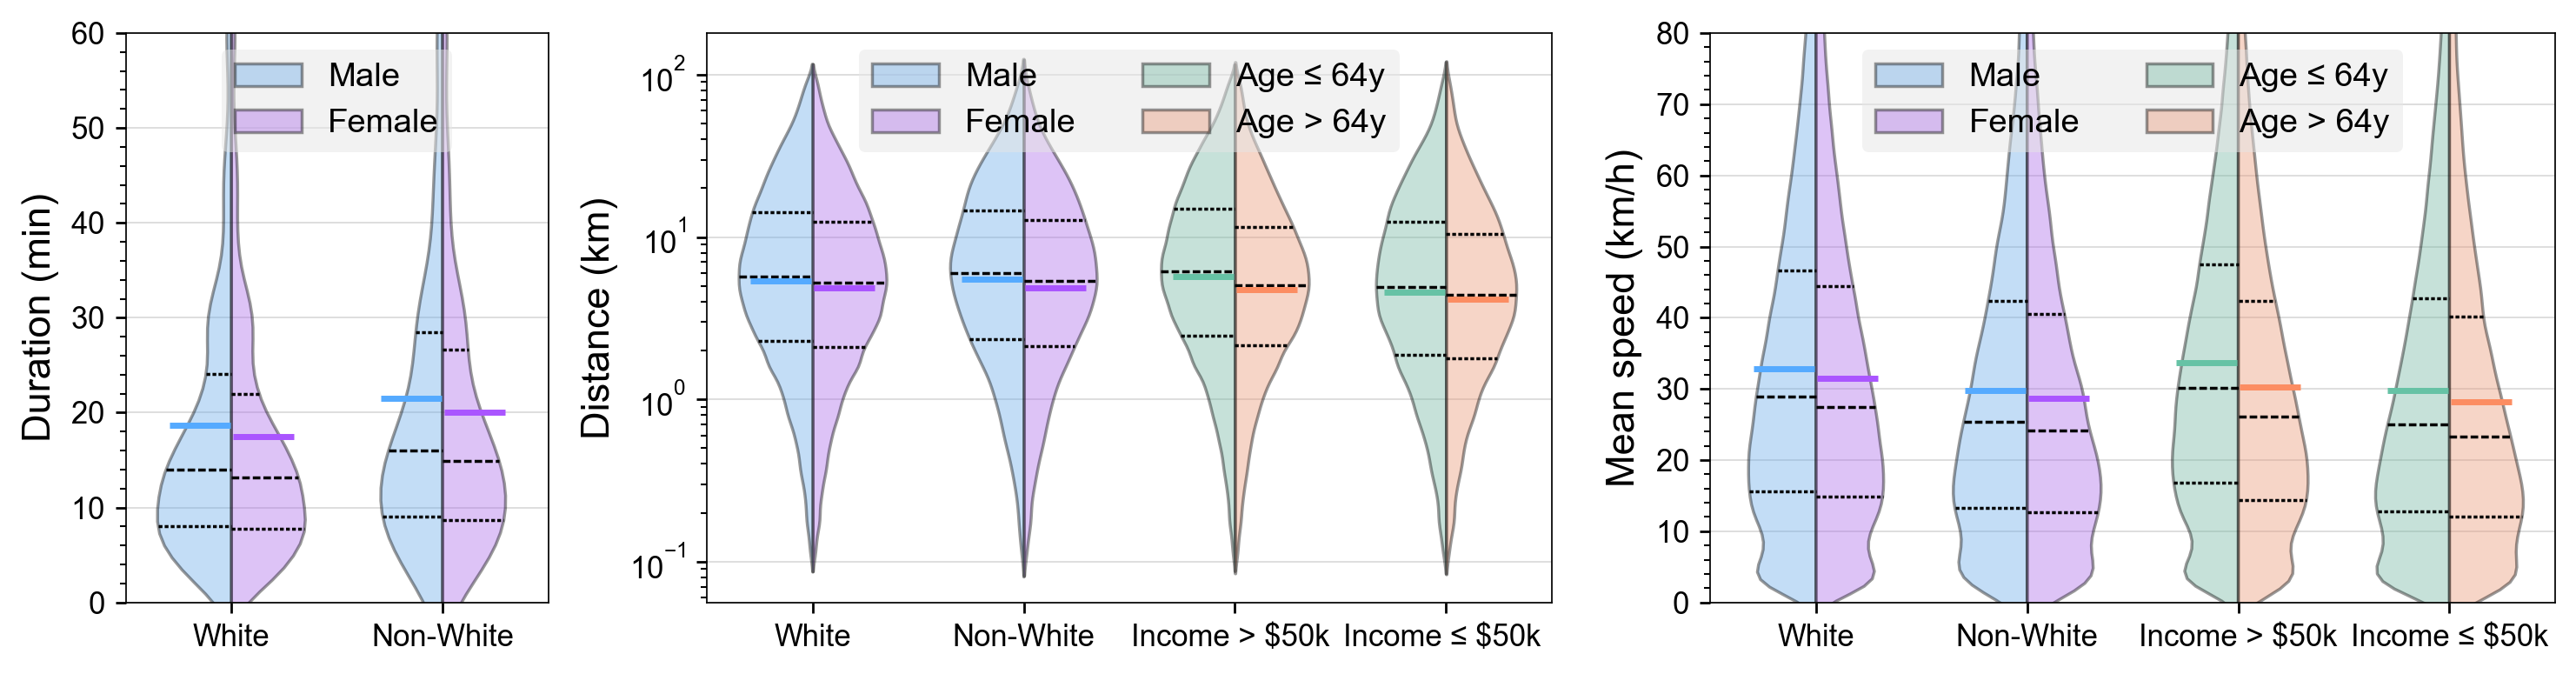

In [19]:
def fig_det_distr_by_ses(trips=trips, size=(12, 3.2), dpi=150):
    df = trips.query('0.1 <= Distance <= 100').copy()
    df.Income = df.Income.map(D(Low='Income ≤ $50k', Mid='Income > $50k', High='Income > $50k'))
    df['Income2'] = df.Income.astype(str) + ' '
    cats = ['Age ≤ 64y', 'Age > 64y']
    df.Age = (df.Age.map(D(Young=cats[0], Mid=cats[0], Senior=cats[1]))
              .astype(CAT).cat.reorder_categories(cats, True))
    fig, axes = plt.subplots(1, 3, figsize=size, dpi=dpi,
                             gridspec_kw=D(width_ratios=[0.5, 1, 1]))
    pbar = tqdm(range(5))
    def violin(ax, y, x, hue, cmap, bw=1, **kw):
        pbar.update()
        ax = pplot(ax, **kw)
        ax = sns.violinplot(df, ax=ax, x=x, y=y, hue=hue, palette=cmap,
                            bw_adjust=bw, cut=1.2, inner='quart', width=0.7,
                            edgecolor='k', linewidth=1, alpha=0.4, split=1)
        return sns.pointplot(df, ax=ax, x=x, y=y, hue=hue, palette=cmap,
                             errorbar=None, dodge=0.3, linestyle='none', legend=False,
                             marker='_', markersize=20, markeredgewidth=2)
    ## Duration
    ax = violin(axes[0], 'Duration', x='Race', hue='Sex', cmap='cool', bw=2)
    ax = pplot(ax, ylim=(0, 60), ylab='Duration (min)', xminor=0)
    ## Distance
    ax = violin(axes[1], 'Distance', x='Race', hue='Sex', cmap='cool', bw=1.2, ylog=1)
    ax = violin(ax, 'Distance', x='Income2', hue='Age', cmap='Set2', bw=1.2, ylog=1)
    ax = pplot(ax, ylab='Distance (km)', xminor=0)
    ## Speed
    ax = violin(axes[2], 'Speed', x='Race', hue='Sex', cmap='cool')
    ax = violin(ax, 'Speed', x='Income', hue='Age', cmap='Set2')
    ax = pplot(ax, ylim=(0, 80), ylab='Mean speed (km/h)', xminor=0)
    for ax, ncol in zip(axes, [1, 2, 2]):
        ax.legend_.set_title('')
        ax.legend(loc='upper center', ncol=ncol)
    fig.tight_layout()
    imsave('Target variables by SES groups')

x = fig_det_distr_by_ses(dpi=250); x # t=0:23

## 4.3. OD: Density & urbanity

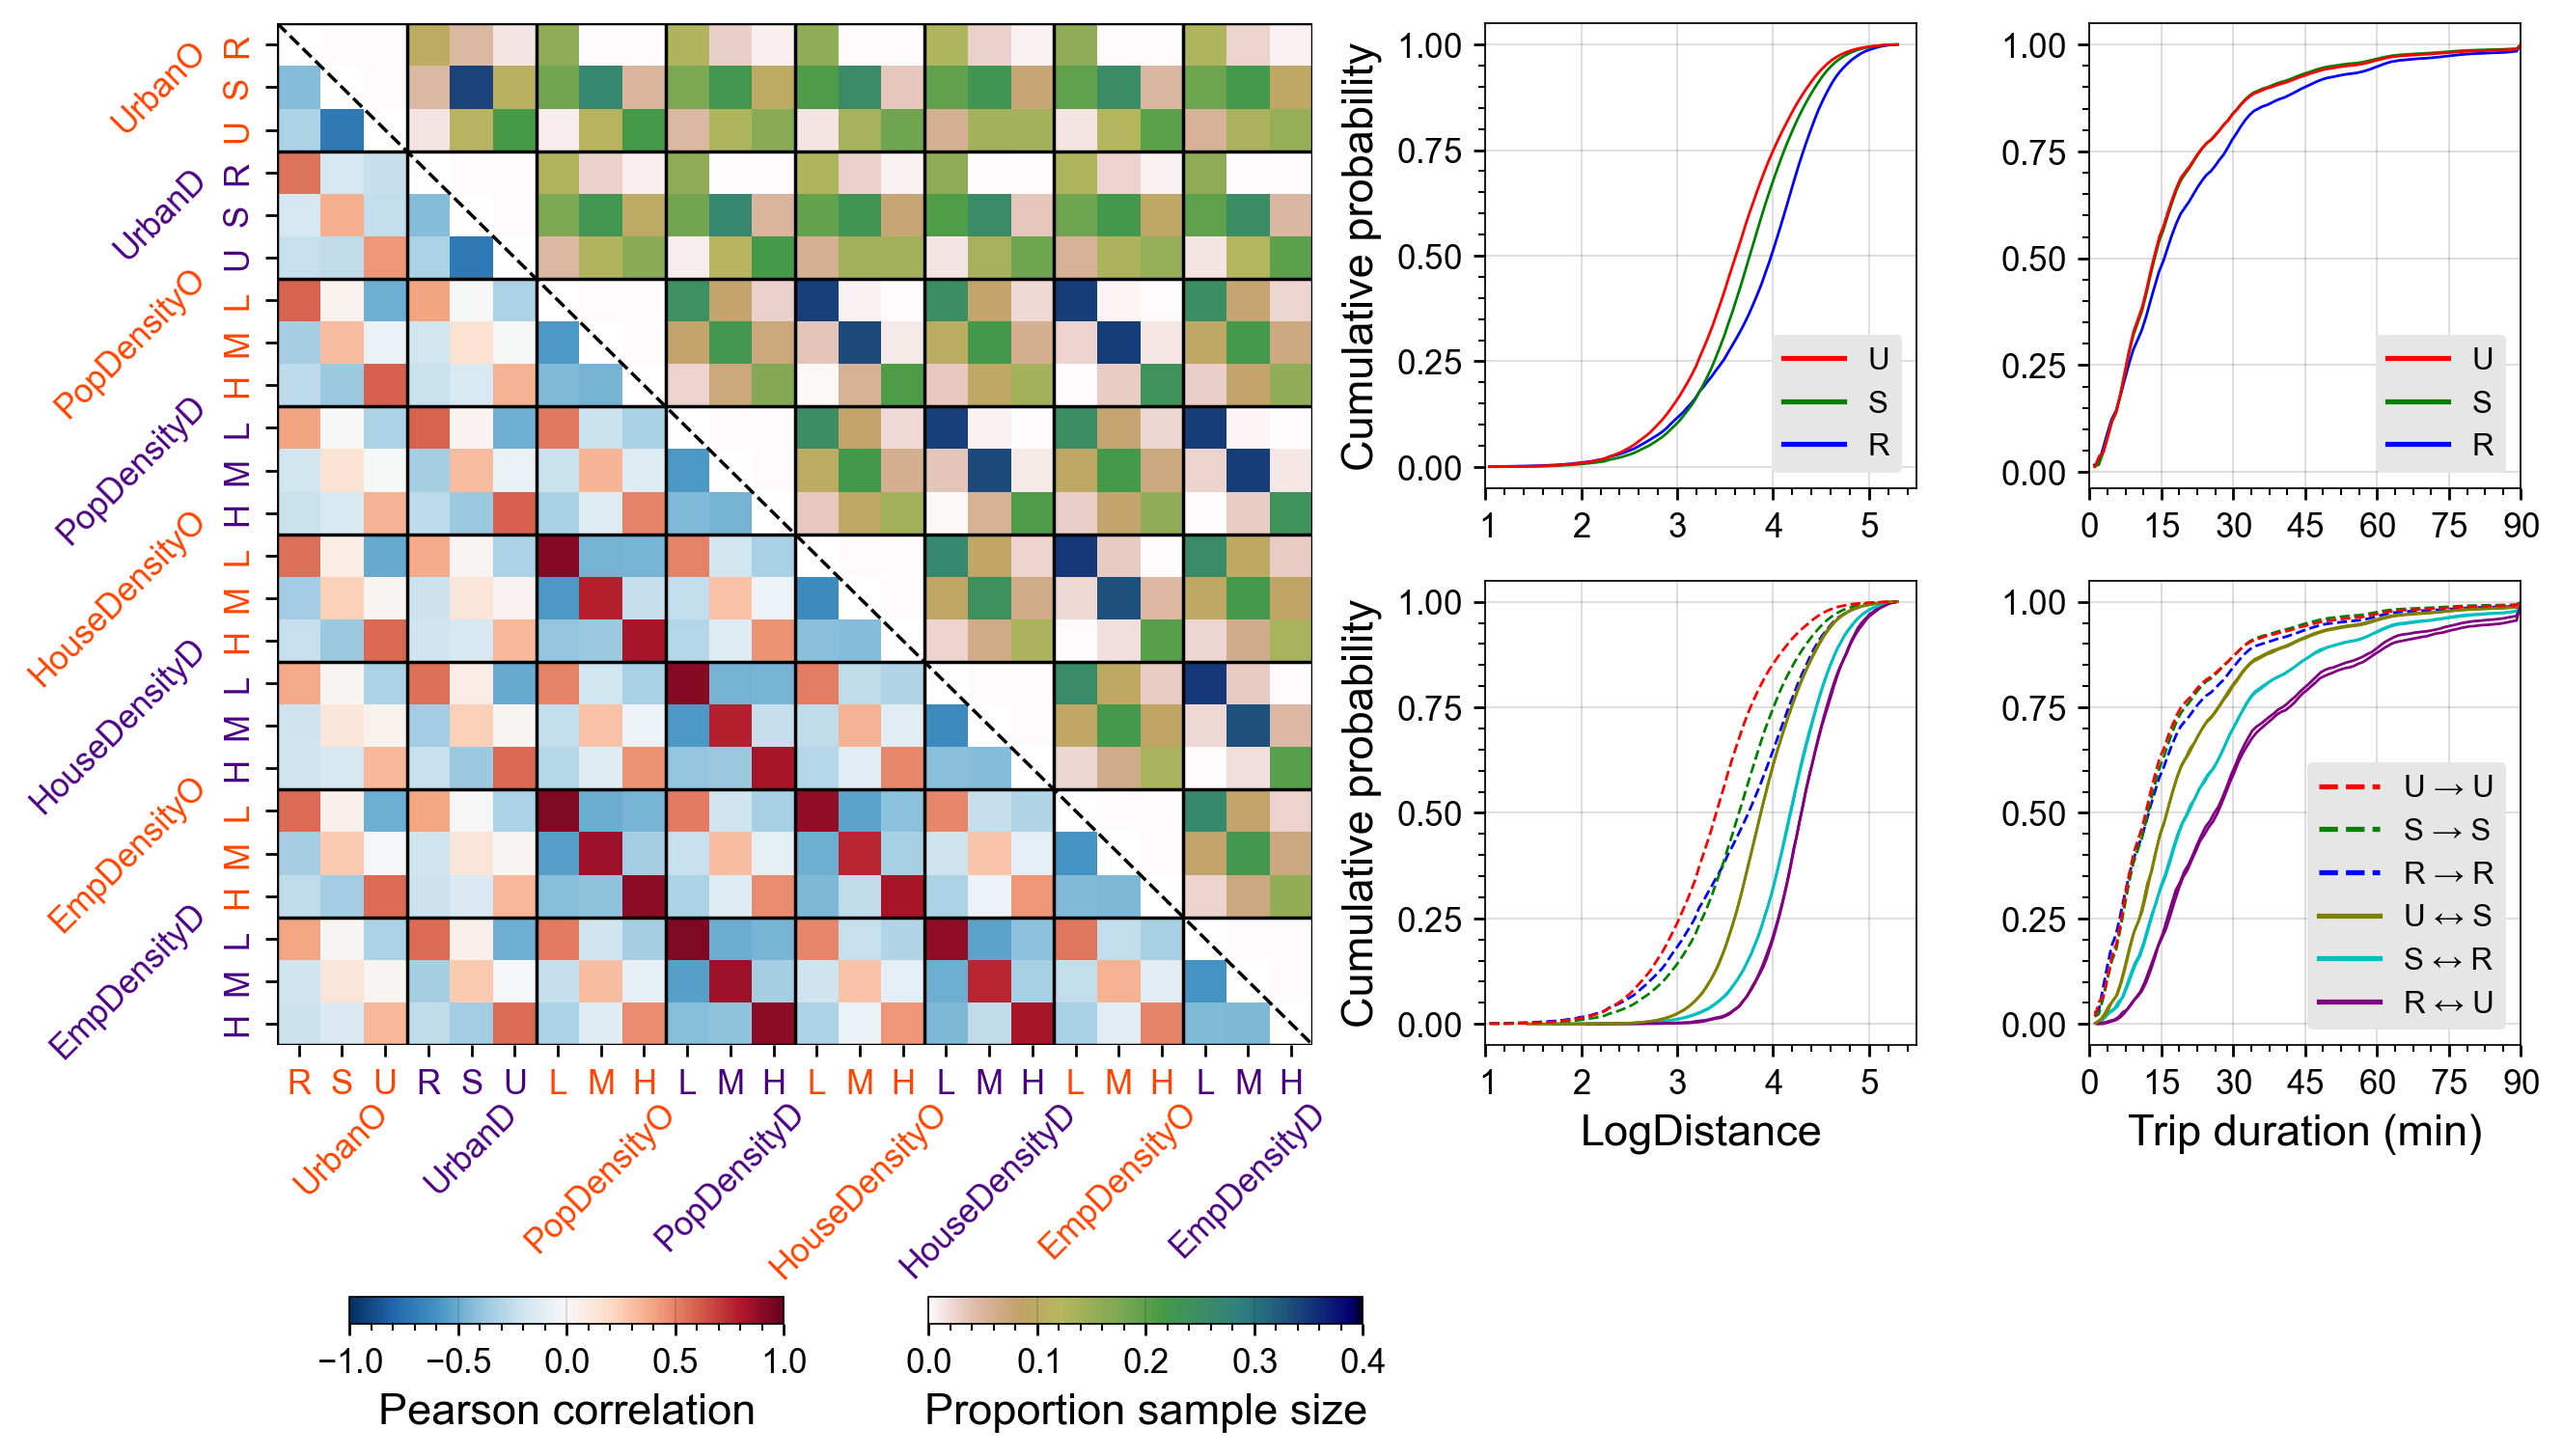

In [14]:
def fig_od_vars(trips=trips, eps=1e-5, size=(12, 5.5), dpi=150):
    feats = ('UrbanO UrbanD PopDensityO PopDensityD HouseDensityO '
             'HouseDensityD EmpDensityO EmpDensityD').split()
    X = pd.get_dummies(trips[feats], prefix_sep='__')
    fig = plt.figure(figsize=size, dpi=dpi)
    gs = fig.add_gridspec(2, 4, wspace=0.4)
    ## Panel 1
    corr = np.tril(X.corr(), -1)
    corr = np.where(corr == 0, np.nan, corr)
    N = np.zeros_like(corr, float) - 1
    for (ix, x), (iy, y) in it.combinations(list(enumerate(X.columns)), 2):
        N[ix, iy] = len(X[X[x] & X[y]]) / len(X)
    N = np.where(N == -1, np.nan, N)
    ax = pplot(fig.add_subplot(gs[:2, :2]), xminor=0, yminor=0, gridcolor='#ffff')
    labels = [x.split('__')[1][0] for x in X.columns]
    for mat, label, vmin, vmax, left, cmap in [
            (corr, 'Pearson correlation', -1, 1, 0.15, 'RdBu_r'),
            (N, 'Proportion sample size', 0, 0.4, 0.35, 'gist_earth_r')]:
        ax = sns.heatmap(mat, ax=ax, cmap=cmap, cbar=0, vmin=vmin, 
                         vmax=vmax, xticklabels=labels, yticklabels=labels)
        cax = fig.add_axes([left, -0.1, 0.15, 0.02])
        scale = mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin, vmax), cmap=cmap)
        fig.colorbar(scale, cax=cax, orientation='horizontal', label=label)
    cols = Pdf(D(col=X.columns))
    cols['feat'] = cols.col.str.split('__').str[0]
    cols['idx'] = (cols.feat.astype(CAT).cat.codes.diff() != 0)
    n = len(cols)
    for x in list(cols.idx[cols.idx].index) + [n]:
        ax.axvline(x, color='k', lw=1)
        ax.axhline(x, color='k', lw=1)
    ax.plot([0, n], [0, n], color='k', ls='--', lw=1)
    colors = D(O='orangered', D='indigo')
    for i, col in enumerate(feats):
        for x, y, ha, va in [(-1.5, i * 3 + 1.5, 'right', 'center'),
                             (i * 3 + 1.5, n + 1.2, 'center', 'top')]:
            ax.text(x, y, col, ha=ha, va=va, rotation=45, color=colors[col[-1]])
    tickcolors = np.repeat(np.tile(list(colors.values()), len(feats) // 2), 3)
    for labs in [ax.get_xticklabels(), ax.get_yticklabels()]:
        for lab, color in zip(labs, tickcolors):
            lab.set_color(color)
    ## Panel 2
    C1 = D(U='r', S='green', R='b') # single colors
    C2 = D(US='olive', SR='c', RU='purple') # unordered pairs
    C2 = {k*2: v for k, v in C1.items()} | C2
    C3 = C2 | {f'{k[1]}{k[0]}': v for k, v in C2.items()} # ordered pairs
    line = lambda label, **kw: mpl.lines.Line2D([0], [0], label=label, **kw)
    for i, target, vmin, vmax, gap, xlab in [
            (0, 'LogDistance', 1, 5.5, 1, 'LogDistance'),
            (1, 'Duration', 0, 90, 15, 'Trip duration (min)')]:
        ## for OD vars
        ax1 = pplot(fig.add_subplot(gs[0, 2 + i]), xlim=(vmin, vmax + eps))
        for level, df in trips.groupby('UrbanO'):
            y, x = np.histogram(df[target].clip(vmin, vmax), bins=100)
            x, y = x[1:], (y / y.sum()).cumsum()
            ax1.plot(x, y, lw=0.8, label=level[0], color=C1[level[0]])
        ax1.legend(fontsize=9, loc='lower right', handles=[
             line(x, color=c) for x, c in C1.items()], framealpha=1)
        ## for flow var
        ax2 = pplot(fig.add_subplot(gs[1, 2 + i]), xlim=(vmin, vmax + 1e-5), xlab=xlab)
        for (src, trg), df in trips.groupby(['UrbanO', 'UrbanD']):
            s, t = src[0], trg[0]
            y, x = np.histogram(df[target].clip(vmin, vmax), bins=100)
            x, y = x[1:], (y / y.sum()).cumsum()
            ax2.plot(x, y, lw=0.8, color=C3[s + t], label=f'{s} → {t}',
                     ls='--' if s == t else '-')
        if i == 1:
            ax2.legend(fontsize=9, loc='lower right', handles=[
                 line(label=f'{x} {"→" if x == y else "↔"} {y}', color=color,
                      ls='--' if x == y else '-')
                 for (x, y), color in C2.items()], framealpha=1)
        for ax in [ax1, ax2]:
            ax.set_xticks(np.arange(vmin, vmax + 1e-5, gap))
            if i == 0: ax.set_ylabel('Cumulative probability')
            ax.set_yticks(np.arange(0, 1.01, .25))
            ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
        imsave('Combining OD factors')

x = fig_od_vars(dpi=250); x

In [15]:
def plot_distr_combined_od(trips=trips, cols=['Urban', 'PopDensity', 'HouseDensity', 'EmpDensity']):
    cols = sum([[x + y for y in 'OD'] for x in cols], [])
    df = trips[cols].apply(lambda x: x.cat.codes)
    x = pd.cut(df.mean(1), [-1, 0.67, 1.33, 3], labels=['Low', 'Mid', 'High'])
    df = pd.concat([trips[['Duration', 'LogDistance', 'Speed']], Pdf(D(density=x))], axis=1)
    _, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
    for i, (trg, rng, bw) in enumerate([
            ('LogDistance', (2, 5), 1),
            ('Duration', (0, 90), 2),
            ('Speed', (0, 80), 1)]):
        ax = pplot(axes[i], xlab=trg, ylab='Probability density' if i == 0 else '')
        sns.kdeplot(df, ax=ax, x=trg, hue='density', bw_adjust=bw, clip=rng)
    plt.tight_layout()

# x = plot_distr_combined_od(); x # t=0:12

## 4.4. Update trips data

In [18]:
trips2 = trips[['Duration', 'Distance', 'Speed', 'Mode', 'Purpose',
                'StayTime', 'MSAKind']].copy().assign(FlowType='')
keymap = D(UU='U → U', SS='S → S', RR='R → R', US='U ↔ S', SR='S ↔ R',
           RU='R ↔ U', SU='U ↔ S', RS='S ↔ R', UR='R ↔ U')
for (src, trg), df in trips.groupby(['UrbanO', 'UrbanD']):
    trips2.loc[df.index, 'FlowType'] = keymap[src[0] + trg[0]]
cats = Series(keymap.values()).drop_duplicates()
trips2.FlowType = pd.Categorical(trips2.FlowType, categories=cats)
trips2.to_parquet('../data/trips2.parquet')